# Part 1: Noise Removal
1. Install Graphcuts for Python by installing from here. Ensure that your python can call "import pygco" (in some setting pygco.py, originally in the gco folder, should be able to be called from your code). On the website, the execution of "make download" might give you an error message, but you don't need to worry as the graphcut code is already provided in the "gco_source" folder.
2. Write a python program to clean up the noise of the image in Figure 1, by employing an MRF and the binary graphcuts. See the pseudocode in C here.


In [1]:
import numpy
import typing
import logging
import cv2
import gco
from gco import pygco
import matplotlib.image
import matplotlib.pyplot
from utils import get_logger, INTEGER_MAX_VALUE

/Users/admin/EE5371/CA2/.venv/lib/python3.8/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [2]:
def compute_distance_normalize(point1: numpy.ndarray, point2: numpy.ndarray) -> float:
    """
    compute distance of two pixels
    Parameters
    ----------
    point1: ndarray, uint8, shape=(3)
        point one
    point2: ndarray, uint8, shape=(3)
        point two
    """
    # return (abs(point1[0]-point2[0]) + abs(point1[1] - point2[1]) + abs(point1[2] - point2[2]) ) / 3 / 255
    # if not dividing 255 as the C pseudocode example, there will be a overflowing of MAX_VALUE of Integer when calling pycgo.cut_grid_graph
    return numpy.sum(numpy.abs(point1-point2)) / 3 / 255
    

In [3]:
logger: logging.Logger = get_logger(__name__)
SOURCE_COLOR: numpy.ndarray = numpy.array(object=[0,0,255])
SINK_COLOR: numpy.ndarray = numpy.array(object=[245,210,110])
NUM_LABELS: int = 2 # the number of labels(freground: SINK_COLOR, background: SOURCE_COLOR)
M_LABMDAS =[0.1,  0.5, 0.9, 0.99,1,1.1,1.2,1.3,1.4,1.5,1.6,1.8,1.9, 2, 3] # change this value to change the weight of the smoothness or prior term

def generate_lablels(m_labmda:int, img_path: str = 'data/bayes_in.jpeg' )-> numpy.ndarray:
    img:numpy.ndarray = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    unary_cost: numpy.ndarray = numpy.zeros(shape=(height, width, NUM_LABELS))
    pairwise_cost = (1 - numpy.eye(NUM_LABELS)) * m_labmda
    # pairwise_cost = numpy.array([[0, INTEGER_MAX_VALUE],
    #                              [INTEGER_MAX_VALUE, 0]])
        # cost_v: ndarray, int32, shape=(height-1, width)
    cost_v: numpy.ndarray = numpy.zeros(shape=(height - 1, width), dtype=numpy.int32)
        # cost_h: ndarray, int32, shape=(height, width-1)
    cost_h: numpy.ndarray = numpy.zeros(shape=(height, width-1), dtype=numpy.int32)
    for y in range(height):
        for x in range(width):
            c: numpy.ndarray = img[y,x, : ]
            # ds1 = compute_distance(c, SINK_COLOR)
            # ds2 = compute_distance(c, SOURCE_COLOR)
            unary_cost[y, x, 0] = compute_distance_normalize(c, SOURCE_COLOR)
            unary_cost[y, x, 1] = compute_distance_normalize(c, SINK_COLOR)
            nx = x + 1
            if nx < width:
                cost_h[y, nx - 1] = m_labmda
            ny = y + 1
            if ny < height:
                cost_v[ny -1, x] = m_labmda
    #    algorithm: string, `expansion` or `swap`, default=expansion
    #  Whether to perform alpha-expansion or alpha-beta-swaps.
    labels:numpy.ndarray = pygco.cut_grid_graph(unary_cost=unary_cost, 
                                                pairwise_cost=pairwise_cost, 
                                                cost_v=cost_v, cost_h=cost_h,
                                                algorithm="expansion").reshape(height, width)
    # noise_removal_img = numpy.zeros_like(a=img)
    output_img = numpy.copy(img)
    for y in range(height):
        for x in range(width):
            id = y * height + x
            if labels[y,x] == 0:
                img[y, x] = SOURCE_COLOR
            elif labels[y,x] == 1:
                img[y, x] = SINK_COLOR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"data/noise_removal_img.png", img)
    img = matplotlib.image.imread("data/noise_removal_img.png")
    matplotlib.pyplot.title(f"noise_removal_img.png, labmda:{m_labmda}")
    matplotlib.pyplot.imshow(X=img)
    matplotlib.pyplot.show()
    return img

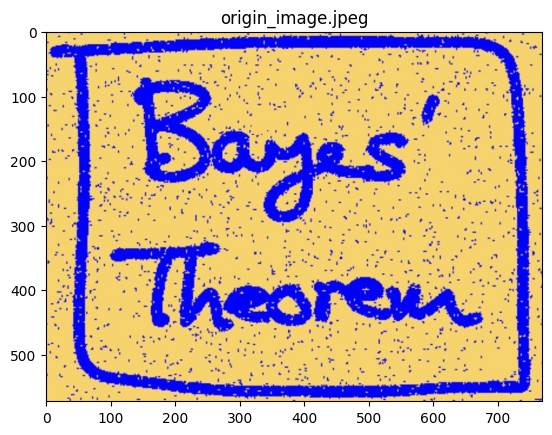

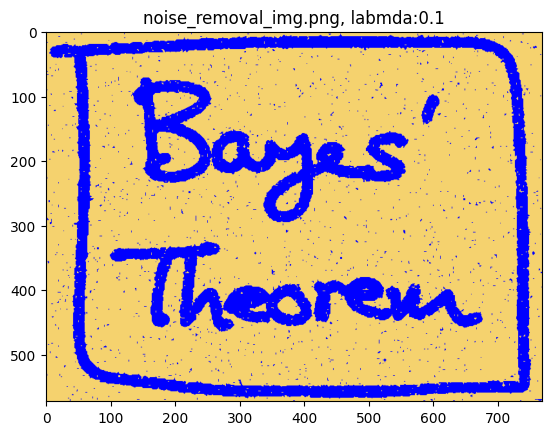

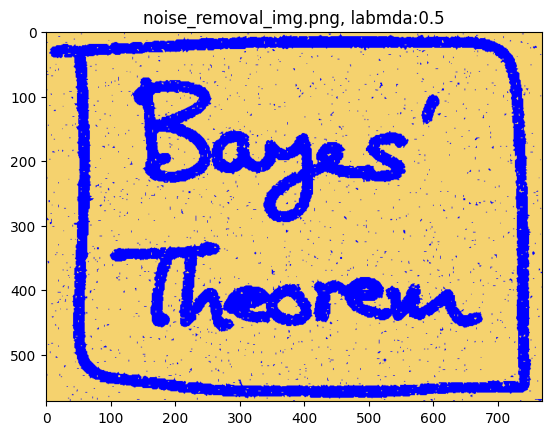

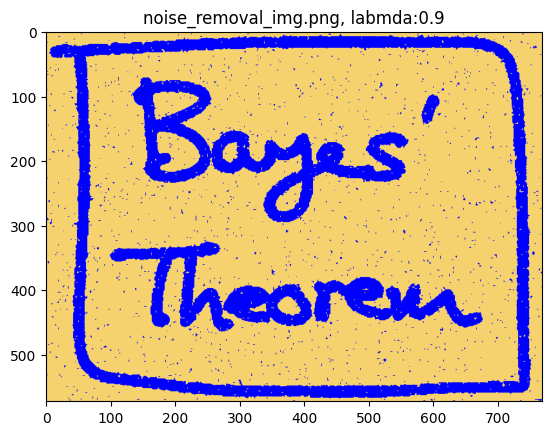

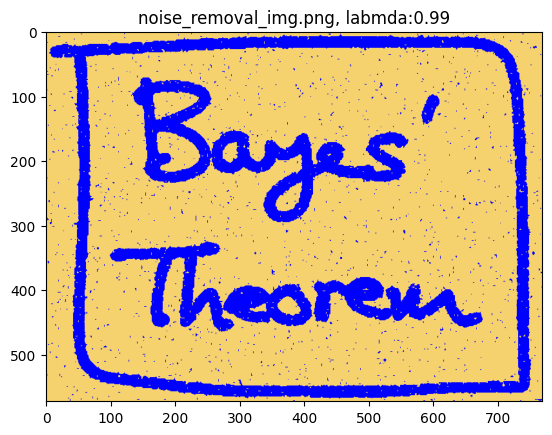

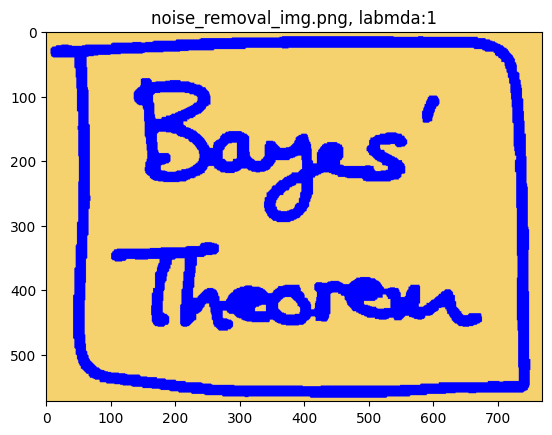

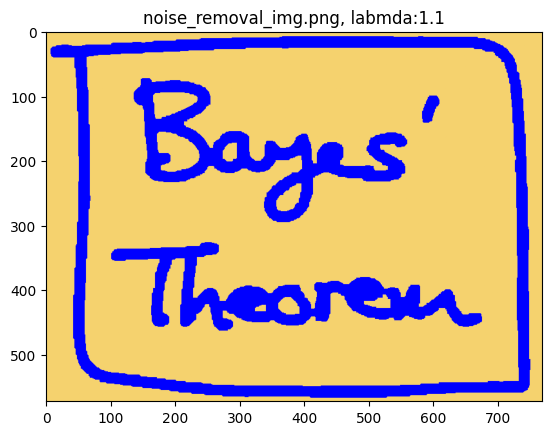

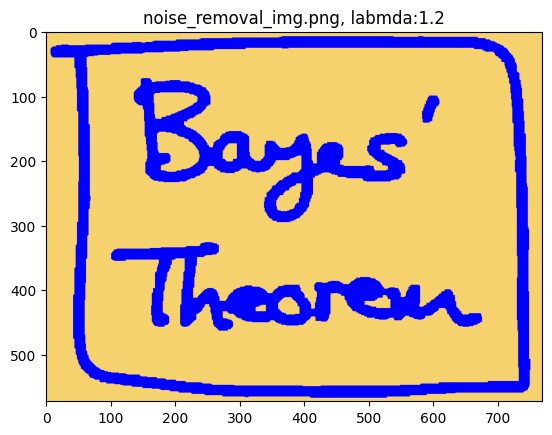

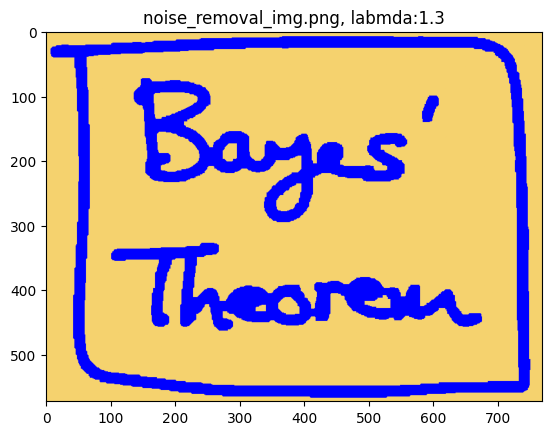

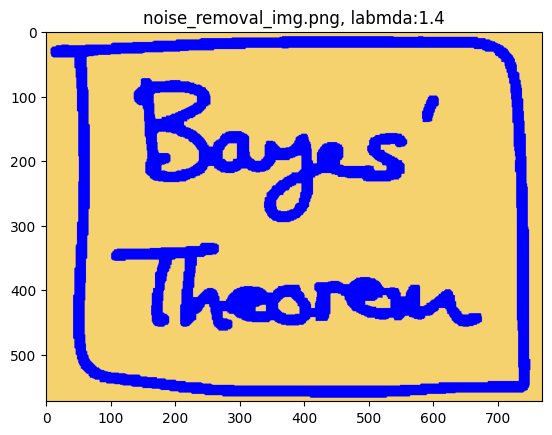

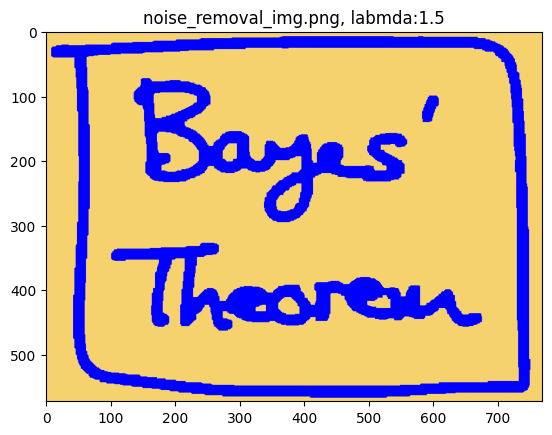

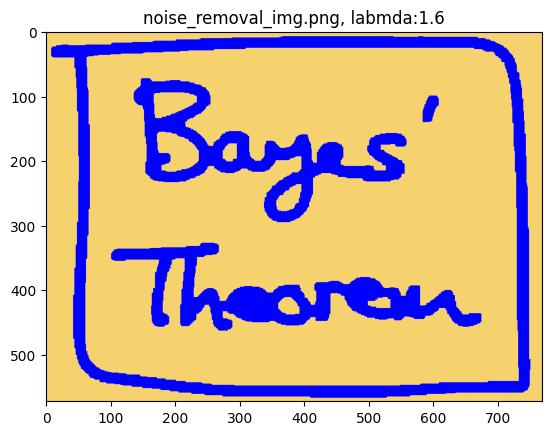

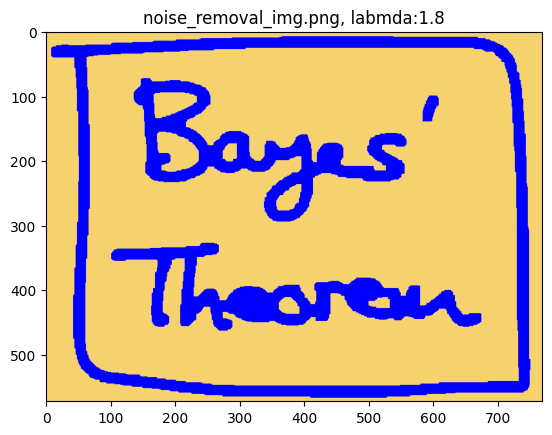

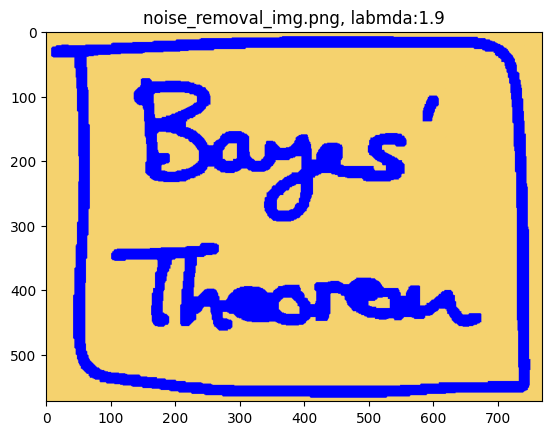

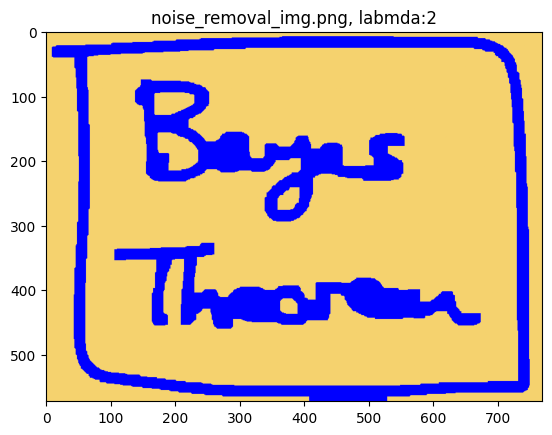

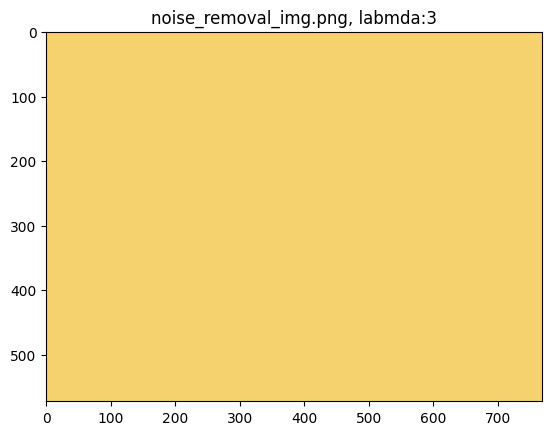

In [4]:
# generate_lablels(m_labmda=0.1)
origin_img = matplotlib.image.imread("data/bayes_in.jpeg")
matplotlib.pyplot.title(f"origin_image.jpeg")
matplotlib.pyplot.imshow(X=origin_img)
matplotlib.pyplot.show()

for m_labmda in M_LABMDAS:
    generate_lablels(m_labmda=m_labmda)